In [39]:
import os
from collections import defaultdict
from PIL import Image

import pandas as pd
import spacy

import numpy as np
import matplotlib.pyplot as plt
from tqdm  import tqdm, trange


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
#from torch.utils.tensorboard import SummaryWriter

from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [40]:
class Vocabulary():
    max_len = 45

    
    def __init__(self, model_name = "gpt2"):
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
    
    def __len__(self):
        return self.tokenizer.vocab_size

    def vocab_size(self):
        return self.tokenizer.vocab_size
    
    def encode(self, text, with_attention_mask: bool = False, padding = False):
        max_seq = None
        if padding:
            max_seq = Vocabulary.max_len
            padding = 'max_length'
        return self.tokenizer(text, padding=padding, max_length=max_seq, return_attention_mask=with_attention_mask)
    
    def decode(self, text, skip_special_tokens=True):
        return self.tokenizer.decode(text, skip_special_tokens=skip_special_tokens)

In [41]:
print(df.caption[30])
vocab.encode(df.caption[30]+vocab.tokenizer.eos_token, padding=False)

A black and white dog is running in a grassy garden surrounded by a white fence .


{'input_ids': [32, 2042, 290, 2330, 3290, 318, 2491, 287, 257, 8701, 88, 11376, 11191, 416, 257, 2330, 13990, 764, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [52]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.eos_token = vocabulary.tokenizer.eos_token
        self.pad_token = vocabulary.tokenizer.pad_token
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            caption += self.eos_token
            caption = self.vocabulary.encode(caption, True, True)
            return img, torch.tensor(caption.input_ids, dtype=torch.long), torch.tensor(caption.attention_mask, dtype=torch.long)
        else:
            captions = torch.zeros(5, self.vocabulary.max_len).to(torch.long)
            atten_mask = torch.zeros(5, self.vocabulary.max_len).to(torch.long)
            for idx, cap in enumerate(caption):
                cap += self.eos_token
                cap = self.vocabulary.encode(cap,True, True)
                captions[idx] = torch.tensor(cap.input_ids, dtype=torch.long)
                atten_mask[idx] = torch.tensor(cap.attention_mask, dtype=torch.long)
            return img, captions, atten_mask

In [53]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [54]:
folder = "data/images/"

In [55]:
vocab = Vocabulary()
vocab.vocab_size()

50257

In [56]:
image_size = 256
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.CenterCrop(224),
                                      #transforms.RandomHorizontalFlip(0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                           std=[0.5, 0.5, 0.5])]) 

val_transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                    std=[0.5, 0.5, 0.5])]) 

In [57]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocab,
                        transform=train_transform, train=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])
['A man holds the hair of a woman to show her matching tattoo .']


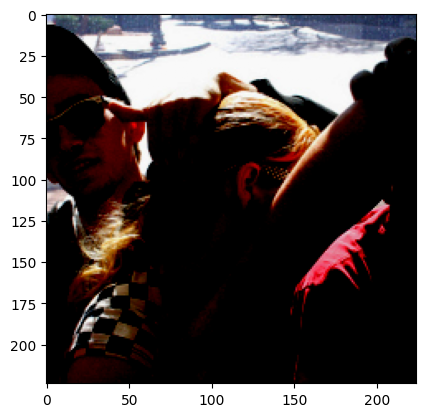

In [65]:
import random
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label, _ = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.imshow(random_image.permute(1, 2,0))
print([vocab.decode(random_label.tolist())])

In [67]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption, _ in train_loader:
    print("Full Batch Caption", caption.shape)
    print("Full Batch Image Shape", image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

Full Batch Caption torch.Size([32, 45])
Full Batch Image Shape torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])
